# Extension ADA : Housing, Health and Happiness

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

%matplotlib inline
plt.rcParams.update({'font.size': 14})

from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [93]:
DATA_FOLDER = 'data/'
DATA_NAME = 'PisoFirme_AEJPol-20070024_household.dta'

data = pd.read_stata(DATA_FOLDER + DATA_NAME)

# Some informations

In [94]:
treated = data.loc[data['dpisofirme'] == 1] #People that attained the program
control = data.loc[data['dpisofirme'] == 0] #People that didn't attain the program

In [95]:
print("Treated group size : ", len(treated))
print("Control group size : ", len(control))

Treated group size :  1390
Control group size :  1393


# I. Replication of the matching of the paper

Maximum of the absolute value of differences between the following four variables for each pair of treatment and control blocks :
* C_blocksdirtfloor
* C_HHdirtfloor
* C_child05
* C_households

In [96]:
def get_max_difference(diff1, diff2, diff3, diff4):
    '''Calculate L-infifnite distance'''
    max_diff = max(abs(diff1), abs(diff2), abs(diff3), abs(diff4))
    return max_diff

In [97]:
get_max_difference(-5, 2, 1, 0.3)

5

In [98]:
# Continuous features from 2000 census
cont_features = ['C_blocksdirtfloor', 'C_HHdirtfloor', 'C_child05', 'C_households',
       'C_people', 'C_rooms', 'C_HHpersons', 'C_waterland', 'C_waterhouse',
       'C_waterbath', 'C_gasheater', 'C_refrigerator', 'C_washing',
       'C_telephone', 'C_vehicle', 'C_overcrowding', 'C_poverty',
       'C_illiterate', 'C_headeduc', 'C_dropouts515', 'C_employment',
       'C_earnincome']

# Creation of a dataframe to normalise continuous features
norm_data = data[cont_features]
norm_data.tail(5)

,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,C_people,C_rooms,C_HHpersons,C_waterland,C_waterhouse,C_waterbath,...,C_washing,C_telephone,C_vehicle,C_overcrowding,C_poverty,C_illiterate,C_headeduc,C_dropouts515,C_employment,C_earnincome
2778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# let's standardize the continuous features
for x in cont_features:
    norm_data[x] = (norm_data[x] -norm_data[x].mean())/norm_data[x].std()
    
norm_data.head(5)

<ipython-input-99-082bf13566fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_data[x] = (norm_data[x] -norm_data[x].mean())/norm_data[x].std()


,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,C_people,C_rooms,C_HHpersons,C_waterland,C_waterhouse,C_waterbath,...,C_washing,C_telephone,C_vehicle,C_overcrowding,C_poverty,C_illiterate,C_headeduc,C_dropouts515,C_employment,C_earnincome
0,-1.414617,-1.024424,-1.874558,0.999996,0.89807,1.643095,-0.255066,-0.612212,-0.936805,-0.942103,...,-1.18468,-2.423538,-0.958559,-1.452089,-1.056768,-0.672601,1.041604,-1.440299,0.424203,0.432818
1,-1.414617,-1.024424,-1.874558,0.999996,0.89807,1.643095,-0.255066,-0.612212,-0.936805,-0.942103,...,-1.18468,-2.423538,-0.958559,-1.452089,-1.056768,-0.672601,1.041604,-1.440299,0.424203,0.432818
2,-1.414617,-1.024424,-1.874558,0.999996,0.89807,1.643095,-0.255066,-0.612212,-0.936805,-0.942103,...,-1.18468,-2.423538,-0.958559,-1.452089,-1.056768,-0.672601,1.041604,-1.440299,0.424203,0.432818
3,-1.414617,-1.024424,-1.874558,0.999996,0.89807,1.643095,-0.255066,-0.612212,-0.936805,-0.942103,...,-1.18468,-2.423538,-0.958559,-1.452089,-1.056768,-0.672601,1.041604,-1.440299,0.424203,0.432818
4,-1.414617,-1.024424,-1.874558,0.999996,0.89807,1.643095,-0.255066,-0.612212,-0.936805,-0.942103,...,-1.18468,-2.423538,-0.958559,-1.452089,-1.056768,-0.672601,1.041604,-1.440299,0.424203,0.432818


In [100]:
treated = data.loc[data['dpisofirme'] == 1] #People that attained the program
control = data.loc[data['dpisofirme'] == 0] #People that didn't attain the program

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control.iterrows():
    for treatment_id, treatment_row in treated.iterrows():

        # Calculate the difference
        max_dist = get_max_difference(control_row['C_child05'] - treatment_row['C_child05'], \
                        control_row['C_blocksdirtfloor'] - treatment_row['C_blocksdirtfloor'], \
                        control_row['C_HHdirtfloor'] - treatment_row['C_HHdirtfloor'], \
                        control_row['C_households'] - treatment_row['C_households'])
        
        inv_dist = 1/max_dist
        
        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, inv_dist)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [101]:
# Matched households in two different dataframe.
# Row 1 of balanced_data_1 corresponds to row 1 of balanced_data_2
# Will be useful for sensitivity analysis
dictio = dict(matching)
balanced_data_1 = data.iloc[list(dictio.keys())]
balanced_data_2 = data.iloc[list(dictio.values())]
balanced_data_1.to_csv(DATA_FOLDER + 'matched_data_1.csv', encoding='utf-8')
balanced_data_2.to_csv(DATA_FOLDER + 'matched_data_2.csv', encoding='utf-8')

In [102]:
# Matching summary

print("Number of treated households : ", len(treated))
print("Number of control households : ", len(control))
print("Number of pairs matched : ", len(matching))
print("Number of pairs NOT matched : ", len(treated)-len(matching))

Number of treated households :  1390
Number of control households :  1393
Number of pairs matched :  1187
Number of pairs NOT matched :  203


In [103]:
# Matched households
data_matched = data.iloc[[subj_id for t in matching for subj_id in t]]
data_matched.head(2)

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
978,0.0,70001893.0,-103.473320,25.565432,7.0,29,0.324324,0.043643,0.765788,982.0,...,22.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.308952
2701,1.0,352650000.0,-103.400169,25.542471,35.0,48,0.300000,0.027318,0.590219,1064.0,...,24.0,22.0,1.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778


In [104]:
data_matched.shape

(2374, 78)

In [105]:
treated_matched = data_matched.loc[data_matched['dpisofirme'] == 1]
control_matched = data_matched.loc[data_matched['dpisofirme'] == 0]

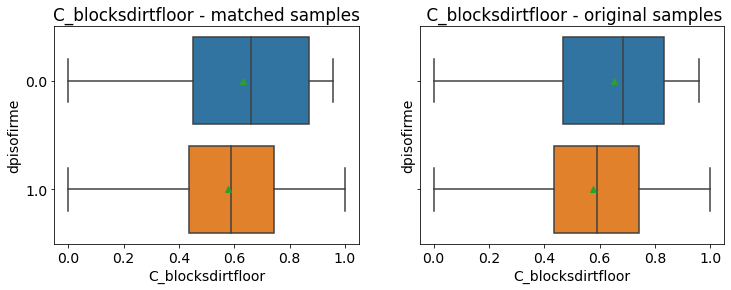

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_blocksdirtfloor'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_blocksdirtfloor - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_blocksdirtfloor'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title(' C_blocksdirtfloor - original samples');

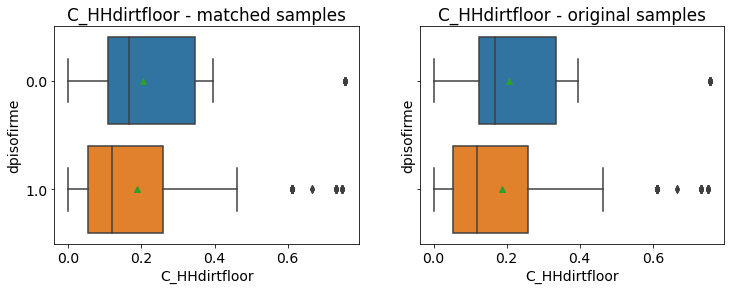

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_HHdirtfloor'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_HHdirtfloor - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_HHdirtfloor'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title('C_HHdirtfloor - original samples');

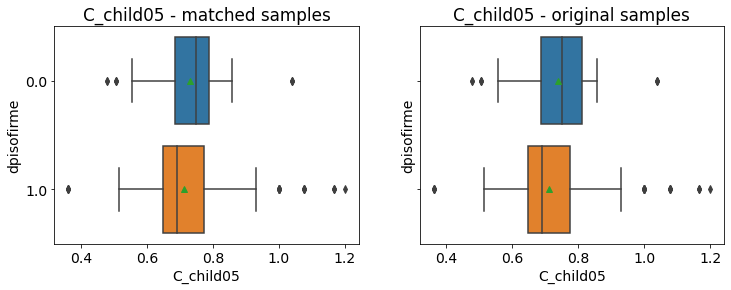

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_child05'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_child05 - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_child05'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title('C_child05 - original samples');

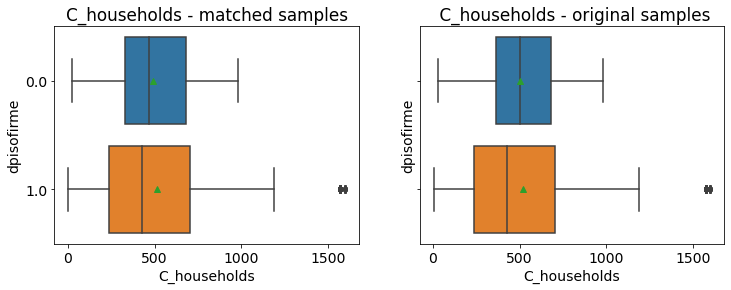

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_households'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_households - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_households'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title(' C_households - original samples');

The distributions don't change very much after the matching.

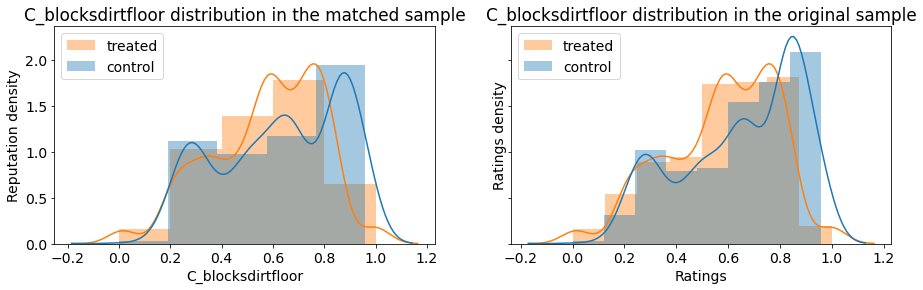

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Reputation
sns.distplot(treated_matched['C_blocksdirtfloor'], hist=True, color='tab:orange', ax=axes[0], bins=5);
sns.distplot(control_matched['C_blocksdirtfloor'], hist=True, color='tab:blue', ax=axes[0], bins=5)
axes[0].set(title='C_blocksdirtfloor distribution in the matched sample', xlabel='C_blocksdirtfloor', ylabel='Reputation density')
axes[0].legend(labels=["treated","control"])

# Ratings
sns.distplot(treated['C_blocksdirtfloor'], hist=True, color='tab:orange', ax=axes[1], bins=8);
sns.distplot(control['C_blocksdirtfloor'], hist=True, color='tab:blue', ax=axes[1], bins=8)
axes[1].set(title='C_blocksdirtfloor distribution in the original sample',xlabel='Ratings', ylabel='Ratings density')
axes[1].legend(labels=["treated","control"]);

# II. Propensity score matching

In [111]:
norm_data.dropna(inplace=True) # Remove empty rows
norm_data['dpisofirme']=data['dpisofirme']

# Definition of the logistic model
mod = smf.logit(formula='dpisofirme ~ C_blocksdirtfloor +  C_HHdirtfloor +  C_child05 +  C_households + C_people +\
                                    C_rooms +  C_HHpersons +  C_waterland +  C_waterhouse + C_waterbath +\
                                    C_gasheater +  C_refrigerator +  C_washing + C_telephone +  C_vehicle +\
                                    C_overcrowding +  C_poverty + C_illiterate +  C_headeduc +  C_dropouts515 +\
                                    C_employment + C_earnincome',  data=norm_data)

res = mod.fit()

# Extract the estimated propensity scores
norm_data['Propensity_score'] = res.predict()

#print(res.summary())

Optimization terminated successfully.
         Current function value: 0.360754
         Iterations 8


<ipython-input-111-848262214b9a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_data.dropna(inplace=True) # Remove empty rows
<ipython-input-111-848262214b9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_data['dpisofirme']=data['dpisofirme']
<ipython-input-111-848262214b9a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [112]:
def get_similarity(propensity_score1, propensity_score2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity_score1-propensity_score2)

In [113]:
# Separate the treatment and control groups
treatment_df = norm_data[norm_data['dpisofirme'] == 1]
control_df = norm_data[norm_data['dpisofirme'] == 0]

# Create an empty undirected graph
G = nx.Graph()

# Loop through all the pairs of instances
for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Calculate the similarity 
        similarity = get_similarity(control_row['Propensity_score'],
                                    treatment_row['Propensity_score'])

        # Add an edge between the two instances weighted by the similarity between them
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

# Generate and return the maximum weight matching on the generated graph
matching = nx.max_weight_matching(G)

In [114]:
# Matched households in two different dataframe.
# Row 1 of balanced_data_1 corresponds to row 1 of balanced_data_2
# Will be useful for sensitivity analysis
dictio = dict(matching)
balanced_data_1 = data.iloc[list(dictio.keys())]
balanced_data_2 = data.iloc[list(dictio.values())]
balanced_data_1.to_csv(DATA_FOLDER + 'prop_matched_data_1.csv', encoding='utf-8')
balanced_data_2.to_csv(DATA_FOLDER + 'prop_matched_data_2.csv', encoding='utf-8')

In [115]:
# Matching summary

print("Number of treated households : ", len(treated))
print("Number of control households : ", len(control))
print("Number of pairs matched : ", len(matching))
print("Number of pairs NOT matched : ", len(treated)-len(matching))

Number of treated households :  1390
Number of control households :  1393
Number of pairs matched :  1187
Number of pairs NOT matched :  203


In [ ]:
# Matched households
data_matched = data.iloc[[subj_id for t in matching for subj_id in t]]

In [116]:
treated_matched = data_matched.loc[data_matched['dpisofirme'] == 1]
control_matched = data_matched.loc[data_matched['dpisofirme'] == 0]

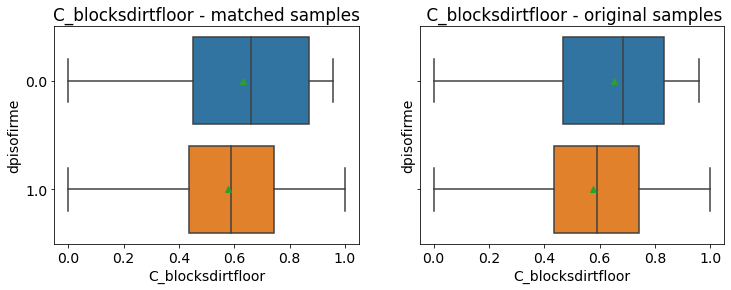

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_blocksdirtfloor'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_blocksdirtfloor - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_blocksdirtfloor'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title(' C_blocksdirtfloor - original samples');

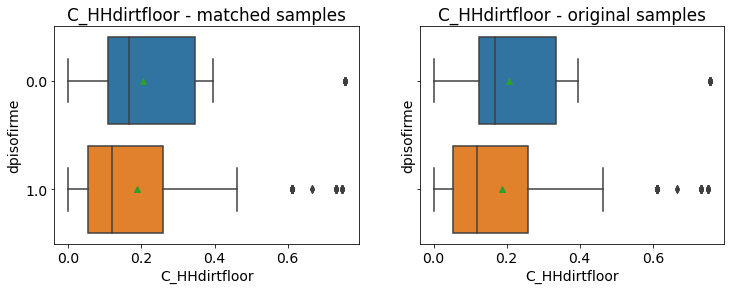

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_HHdirtfloor'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_HHdirtfloor - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_HHdirtfloor'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title('C_HHdirtfloor - original samples');

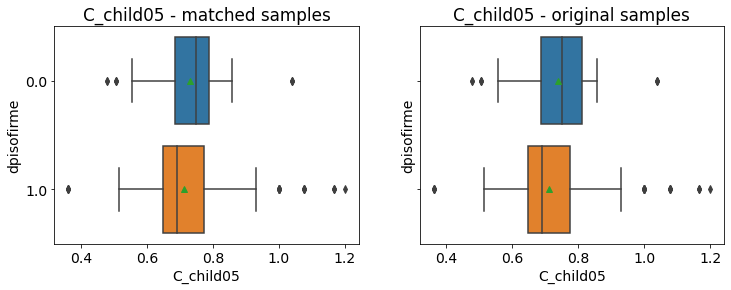

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_child05'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_child05 - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_child05'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title('C_child05 - original samples');

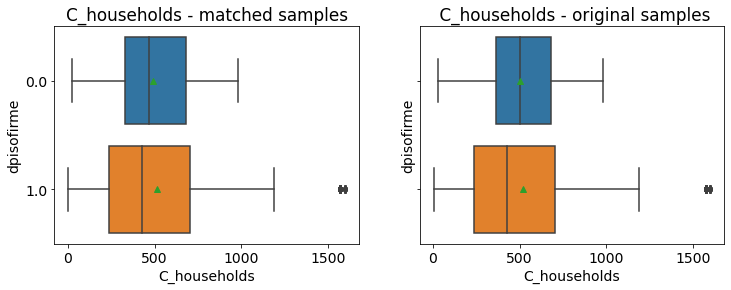

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# Reputation
sns.boxplot(ax=axes[0], x=data_matched['C_households'], y=data_matched['dpisofirme'], showmeans=True, orient='h');
axes[0].set_title('C_households - matched samples')

# Ratings
sns.boxplot(ax=axes[1], x=data['C_households'], y=data['dpisofirme'], showmeans=True, orient='h');
axes[1].set_title(' C_households - original samples');

The distributions don't change very much after the matching.

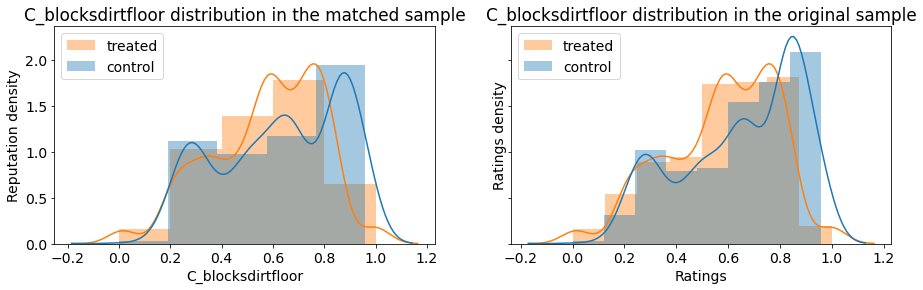

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Reputation
sns.distplot(treated_matched['C_blocksdirtfloor'], hist=True, color='tab:orange', ax=axes[0], bins=5);
sns.distplot(control_matched['C_blocksdirtfloor'], hist=True, color='tab:blue', ax=axes[0], bins=5)
axes[0].set(title='C_blocksdirtfloor distribution in the matched sample', xlabel='C_blocksdirtfloor', ylabel='Reputation density')
axes[0].legend(labels=["treated","control"])

# Ratings
sns.distplot(treated['C_blocksdirtfloor'], hist=True, color='tab:orange', ax=axes[1], bins=8);
sns.distplot(control['C_blocksdirtfloor'], hist=True, color='tab:blue', ax=axes[1], bins=8)
axes[1].set(title='C_blocksdirtfloor distribution in the original sample',xlabel='Ratings', ylabel='Ratings density')
axes[1].legend(labels=["treated","control"]);